In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
from itertools import zip_longest
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
x = tf.Variable(-0.75)
y = tf.Variable(0.001)

loss = tf.square(x) - tf.square(y)

In [3]:
lr = 0.05
optimizers = [tf.train.GradientDescentOptimizer(lr), \
              tf.train.MomentumOptimizer(learning_rate=lr, momentum=0.9),\
              tf.train.MomentumOptimizer(learning_rate=lr, momentum=0.9, use_nesterov=True, name="Nestrov"),\
              tf.train.AdamOptimizer(lr), \
              tf.train.AdadeltaOptimizer(1),\
              tf.train.AdagradOptimizer(1), \
             ]
paths_ = {}

In [4]:
for optimizer in optimizers:
    history = []
    print(optimizer.get_name())
    train = optimizer.minimize(loss)
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    for i in range(100):
        x0, y0, loss0 = sess.run([x, y, loss])
        history.append([x0,y0,loss0])
        sess.run(train)
    paths_[optimizer.get_name()] = np.array(history)

GradientDescent
Momentum
Nestrov
Adam
Adadelta
Adagrad


In [5]:
x_span = np.linspace(-1, 1.)
y_span = np.linspace(-0.5, 1.)
xmesh, ymesh = np.meshgrid(x_span, y_span)

In [6]:
zmesh =  xmesh ** 2 - ymesh**2

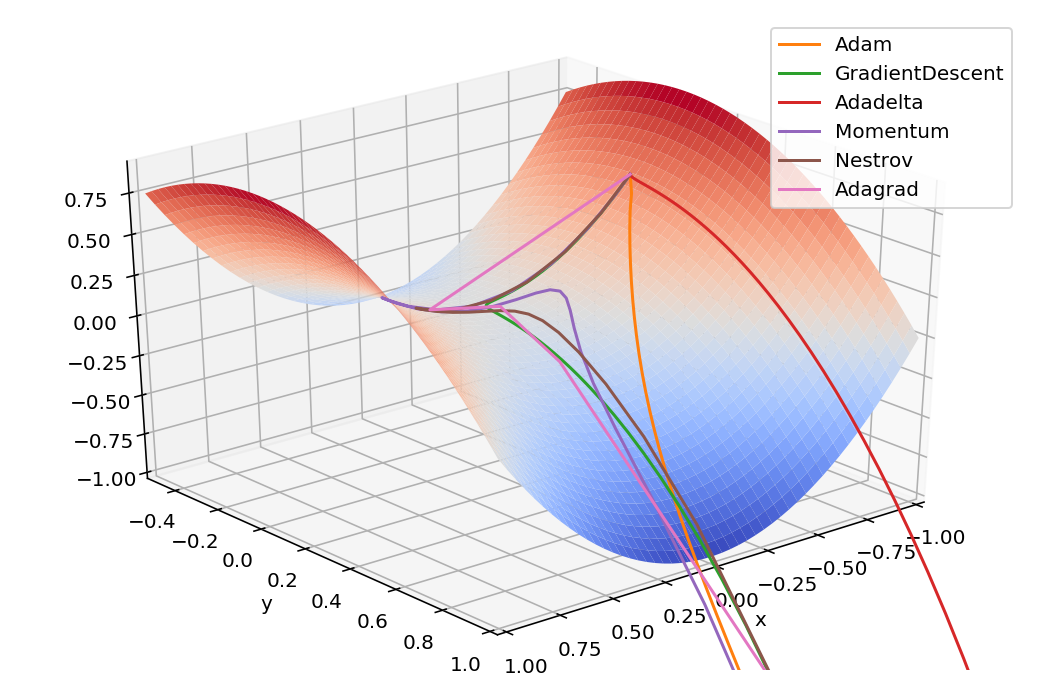

In [7]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.plot_surface(xmesh, ymesh, zmesh, cmap="coolwarm")
ax.view_init(azim=50, elev=30)
for key, value in paths_.items():
    ax.plot(value[:,0], value[:,1], value[:,2], label=key)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-1, 1])
plt.ylim([-0.5, 1])
ax.set_zlim([-1.0, 0.9])
ax.legend()
plt.show()

In [8]:
class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(self, *paths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths

        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points

In [9]:
class TrajectoryAnimation3D(animation.FuncAnimation):
    
    def __init__(self, *paths, zpaths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths
        self.zpaths = zpaths
        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]

        super(TrajectoryAnimation3D, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line in self.lines:
            line.set_data([], [])
            line.set_3d_properties([])
        return self.lines

    def animate(self, i):
        for line, path, zpath in zip(self.lines, self.paths, self.zpaths):
            line.set_data(*path[::,:i])
            line.set_3d_properties(zpath[:i])
        return self.lines

In [10]:
xypaths  = [val[:,0:2].T.astype(np.float64) for _, val in paths_.items()]
zpaths  = [val[:,2].T.astype(np.float64) for _, val in paths_.items()]
methods  = [key for key, _ in paths_.items()]

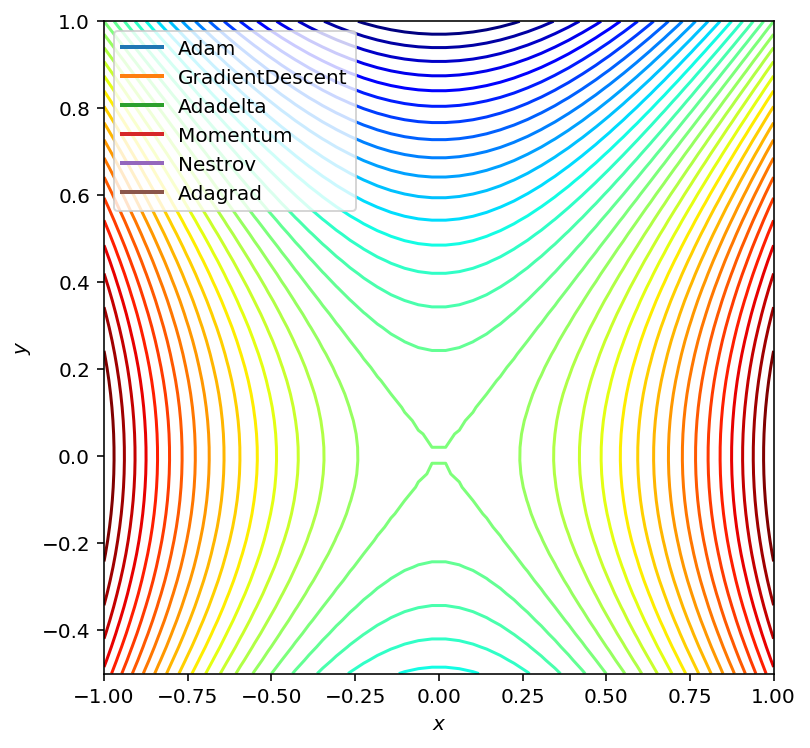

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.contour(xmesh, ymesh, zmesh, levels=np.linspace(-1, 1, 35), cmap=plt.cm.jet)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.xlim([-1, 1])
plt.ylim([-0.5, 1])

anim = TrajectoryAnimation(*xypaths, labels=methods, ax=ax, frames=100)

ax.legend(loc='upper left')

In [12]:
HTML(anim.to_html5_video())

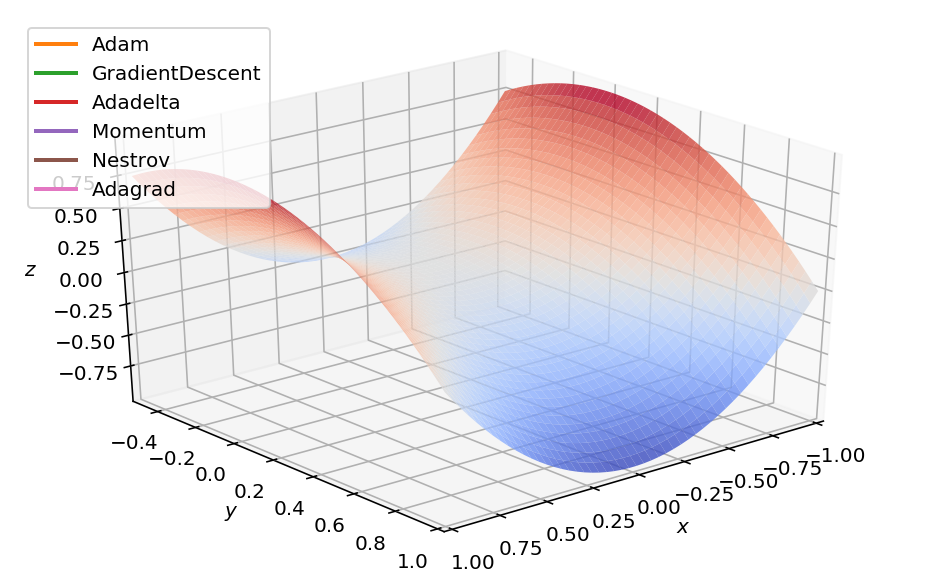

In [13]:
fig = plt.figure(figsize=(8, 5))
ax = fig.gca(projection='3d')
ax.plot_surface(xmesh, ymesh, zmesh, edgecolor='none', alpha=.8, cmap="coolwarm")
ax.view_init(azim=50, elev=30)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((-1, 1))
ax.set_ylim((-0.5, 1))

anim = TrajectoryAnimation3D(*xypaths, zpaths=zpaths, labels=methods, ax=ax)

ax.legend(loc='upper left')

In [14]:
HTML(anim.to_html5_video())